In [24]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import networkx as nx
import pandas as pd
import numpy as np
sys.path.insert(0, Path.cwd().absolute())

BASE_DIR = (Path.cwd()).parent

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from network_analysis.flow_assignment import FlowAssignment
from geoprocessing.faf_zone_network import FafZoneNetwork, link_weights
from network_analysis.mc_flow_assignment import sample_flows
import geopandas as gpd

In [26]:
SIMPLE_NET =  (421, 423, 341, 342 )

MONTE_CARLO = False
MC_ITER_N = 500
NORMAL_DIST = True

COLUMN = 'thousand tons in 2035'

# Validations
if SIMPLE_NET:
  MONTE_CARLO = False
  

In [27]:
naRailNodesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Nodes")
naRailLinesDf = gpd.read_file( BASE_DIR / "inputs/NTAD_North_American_Rail_Network_Lines")
fafZonesDf = gpd.read_file( BASE_DIR / "inputs/2017_CFS_Metro_Areas_with_FAF").to_crs(4326)
fzn = FafZoneNetwork(naRailNodesDf, naRailLinesDf, fafZonesDf).setInputDfColType()
if SIMPLE_NET:
  fzn.fafZonesDf = fzn.fafZonesDf.loc[fzn.fafZonesDf.FAF_Zone.isin(SIMPLE_NET)]
  faf_flows = pd.DataFrame([
    [ 421, 423, 10],
    [421,341, 77],
    [342, 423, 96]
  ], columns=['dms_orig', 'dms_dest', COLUMN])
  display(SIMPLE_NET)
  display(faf_flows)
else:
  faf_flows = pd.read_csv(Path.cwd().parent / 'inputs/faf_freight_flow.csv' )
  display(faf_flows)
fzn.network_weight_fn = link_weights
railnet = fzn.createNetwork()

(421, 423, 341, 342)

,dms_orig,dms_dest,thousand tons in 2035
0,421,423,10
1,421,341,77
2,342,423,96


In [28]:

fa = FlowAssignment(railnet)

railnet_flows = fa.run(faf_flows, SUM_COLUMN=COLUMN) # For comparison, if Monte Carlo mode
if not MONTE_CARLO:
  fzn.apply_flows(railnet_flows.to_dict())

if MONTE_CARLO:
  monte_railnet_flows = []
  monte_inputs = []
  for i in range(MC_ITER_N):
    iteration_inputs = sample_flows(faf_flows, COLUMN, distribution='normal' if NORMAL_DIST else 'triangular')
    monte_inputs.append(iteration_inputs)
    faf_flows['input_flows'] = iteration_inputs
    iteration_flow = fa.run(faf_flows, SUM_COLUMN='input_flows')
    monte_railnet_flows.append(iteration_flow)
  monte_railnet_flows = pd.concat(monte_railnet_flows, axis=1)
  monte_railnet_flows.columns=range(MC_ITER_N)
  fzn.fafZoneLinksDf['flows'] = monte_railnet_flows.mean(axis=1)
  fzn.fafZoneLinksDf['flow_covs'] = monte_railnet_flows.std(axis=1) / monte_railnet_flows.mean(axis=1)
  railnet_flows.index = railnet_flows.index.set_names({'seg_start':'FAF_Zone_fr', 'seg_end':'FAF_Zone_to'})
  fzn.fafZoneLinksDf['flow_df'] = (fzn.fafZoneLinksDf['flows'] - railnet_flows).abs()
  fzn.fafZoneLinksDf['flow_df_percent'] = fzn.fafZoneLinksDf['flow_df'] / railnet_flows

,FAF_Zone_1_fr,FAF_Zone_1_to,flowr
0,"New York-Newark, NY-NJ-CT-PA CFS Area (NJ Part)","Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ...",96.0
1,"New York-Newark, NY-NJ-CT-PA CFS Area (NJ Part)","New York-Newark, NY-NJ-CT-PA CFS Area (PA Part)",96.0
2,"New York-Newark, NY-NJ-CT-PA CFS Area (NJ Part)","Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ...",77.0
3,"Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ...","New York-Newark, NY-NJ-CT-PA CFS Area (PA Part)",10.0
4,"Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ...","Philadelphia-Reading-Camden, PA-NJ-DE-MD CFS ...",0.0


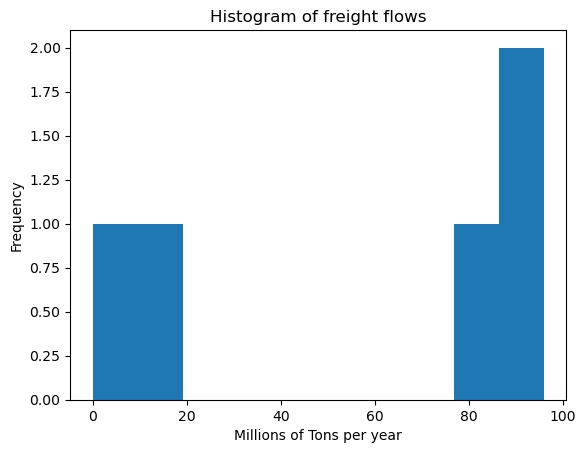

In [31]:
import matplotlib.pyplot as plt

import folium
import branca.colormap as cm
from IPython.display import display


min_lat=24.7433195
max_lat=49.3457868
min_lon=-124.7844079
max_lon=-66.9513812


m = folium.Map(
  max_bounds=True,
  location=[42, -95],
  zoom_start=4,
  min_zoom=4,
  tiles='OpenStreetMap',
  # max_lat=max_lat,
  # min_lon=min_lon,
  # max_lon=max_lon,
  # min_lat=min_lat
)

m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
wmax = fzn.fafZoneLinksDf['flows'].max()
wmin = fzn.fafZoneLinksDf['flows'].min()
def norm_w(feature):
  return (feature['properties']['flows'] - wmin)/(wmax-wmin)

lineWeightMax = 4
lineWeightMin = 0.75

if True:
  zoneDf = fzn.fafZonesDf.copy()
  zoneDf.geometry = zoneDf.geometry.simplify(.15)
  zoneDf[['FAF_Zone_1', 'geometry']].explore(
    m=m,
    column='FAF_Zone_1',
    cmap='Greens',
    legend=False,
    style_kwds={'opacity':.1}
  )

if False: 
  from folium import DivIcon
  for i, r in fzn.fafZoneLinksDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 12px">%s</div>' % round(r.flows,4),
        )
    ).add_to(m)


  for i, r in fzn.fafZoneNodesDf.iterrows():
    center = r.geometry.centroid
    folium.map.Marker(
      [center.y, center.x],
      icon=DivIcon(
          icon_size=(20,150),
          icon_anchor=(0,0),
          html='<div style="font-size: 16px; font-weight: bold">%s</div>' % int(i),
        )
    ).add_to(m)


fzn.fafZoneLinksDf[['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flows', 'geometry']].explore(
  m=m,
  column='flows',
  style_kwds={
    'style_function': lambda feature: {
      'color': cm.linear.plasma(norm_w(feature)),
      'weight': norm_w(feature) * (lineWeightMax - lineWeightMin) + lineWeightMin
    }
  }
)

fzn.fafZoneNodesDf[['FAF_Zone_1', 'geometry']].explore(
  m=m,
  color='black'
)
display(m)
if MONTE_CARLO:
  fzn.fafZoneLinksDf['flow_df%'] = (fzn.fafZoneLinksDf['flow_df_percent'] * 100).round(2)
fzn.fafZoneLinksDf['flowr'] = fzn.fafZoneLinksDf['flows'].round()

display(fzn.fafZoneLinksDf.sort_values('flows', axis=0, ascending=False).reset_index()[
  ['FAF_Zone_1_fr', 'FAF_Zone_1_to', 'flowr'] + (['flow_df%', 'flow_covs', 'flow_df', ] if MONTE_CARLO else [])
].head(10))
fzn.fafZoneLinksDf['flows'].plot(
  kind='hist',
  title='Histogram of freight flows',
  xlabel='Millions of Tons per year'
)
plt.show()

if MONTE_CARLO:
  from matplotlib.ticker import PercentFormatter

  diff_percents = monte_railnet_flows.sub(railnet_flows, axis=0).abs().div(railnet_flows, axis=0).mul(100, axis=0)
  plot = diff_percents.T.expanding().mean().abs().mean(axis=1).plot(
    title='Monte Carlo Simulation Convergence',
    xlabel='Iterations',
    ylabel='Precent Error'
  )
  plot.yaxis.set_major_formatter(PercentFormatter())
  plt.show()
  avg_diff_percents = diff_percents.mean(axis=1)
  fzn.fafZoneLinksDf.loc[~np.isfinite(fzn.fafZoneLinksDf.flow_df_percent), 'flow_df_percent'] = 0
  plot = avg_diff_percents.plot(
    kind='hist',
    title='Histogram of flow errors in percent',
    xlabel='Percent Error'
  )
  mean_error = avg_diff_percents.mean()
  plt.axvline(mean_error, color='k')
  plot.xaxis.set_major_formatter(PercentFormatter())
  
  min_ylim, max_ylim = plt.ylim()
  plt.text(mean_error * 1.1, max_ylim*0.9, 'Mean: {:.4f}%'.format(mean_error))
  plt.show()